In [1]:
import pandas as pd
import dash
import dash_table
import dash_html_components as html
import dash_core_components as dcc
from dash.dependencies import Output, Input
import pandas as pd  # pip install pandas
import plotly.express as px
import math
from dash import no_update
import plotly.offline as pyo
import plotly.graph_objects as go
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.colors as colors
import matplotlib.cbook as cbook
import matplotlib as mpl
from matplotlib import cm
import base64
import random
import PIL
from PIL import Image

In [2]:
#orginal dataframe
df_orginal = pd.read_csv("YInt.csv")
#add ts for filtering 
df_orginal['ts'] = pd.to_datetime(df_orginal['time']).values.astype(np.int64) // 10 ** 9
df_orginal

,time,location,account,message,ts
0,2020-04-06 00:00:00,Weston,Opportunities2,"Take advantheeseage of theesehese One, theeser...",1586131200
1,2020-04-06 00:00:00,Southton,LazyBCouch,@WatchesThomasBird fork it you're back in he s...,1586131200
2,2020-04-06 00:02:00,Southton,______3333_____,Two month left bedoreefore you loose this vibe...,1586131320
3,2020-04-06 00:04:00,Broadview,RasoHorse49,"billeeeeer, i miss ytouou !",1586131440
4,2020-04-06 00:07:00,West Parton,CuriousPlateBobbie_Mallon,You obviously need to use rumble! #rumble #toW...,1586131620
...,...,...,...,...,...
41936,2020-04-10 11:59:00,Cheddarford,DerekNolan,next were going to watch them take down our ho...,1586519940
41937,2020-04-10 11:59:00,Safe Town,WileyPlateHunter,someone something something On someone he they...,1586519940
41938,2020-04-10 11:59:00,East Parton,LazyCBowl,re: Do yall think i can take my yacht out for ...,1586519940
41939,2020-04-10 11:59:00,Weston,JonesWhale21,re: guys we have no water and mittens and i ha...,1586519940


In [3]:
df = pd.read_csv("df_final.csv")
list_region = df['location'].unique().tolist()
list_region_without_all = list_region
list_region.append('All')
print(list_region)

['Weston', 'Southton', 'Broadview', 'West Parton', 'Old Town', 'Terrapin Springs', 'Downtown', 'Southwest', 'Scenic Vista', 'East Parton', 'Cheddarford', 'Palace Hills', 'Safe Town', 'Easton', 'Chapparal', 'Northwest', 'Oak Willow', 'Pepper Mill', 'Wilson Forest', 'UNKNOWN', '<Location with-held due to contract>', 'All']


In [4]:
by_hour = pd.to_datetime(df['time']).dt.to_period("H").value_counts().sort_index()
by_hour.index = pd.PeriodIndex(by_hour.index)

df_hour = by_hour.rename_axis('hour').reset_index(name='counts')
df_hour

,hour,counts
0,2020-04-06 00:00,24
1,2020-04-06 01:00,18
2,2020-04-06 02:00,22
3,2020-04-06 03:00,34
4,2020-04-06 04:00,76
...,...,...
103,2020-04-10 07:00,766
104,2020-04-10 08:00,312
105,2020-04-10 09:00,617
106,2020-04-10 10:00,357


In [5]:
df_region = []
for region in list_region_without_all:
  by_hour = pd.to_datetime(df['time'].loc[df['location']==region]).dt.to_period("H").value_counts().sort_index()
  by_hour.index = pd.PeriodIndex(by_hour.index)

  df_hour = by_hour.rename_axis('hour').reset_index(name='counts')
  df_hour['hour'] = df_hour['hour'].astype(str)
  df_region.append(df_hour)

by_hour = pd.to_datetime(df['time']).dt.to_period("H").value_counts().sort_index()
by_hour.index = pd.PeriodIndex(by_hour.index)

df_hour = by_hour.rename_axis('hour').reset_index(name='counts')
df_hour['hour'] = df_hour['hour'].astype(str)
df_region.append(df_hour)

In [6]:
ts = pd.to_datetime(df['time']).values.astype(np.int64) // 10 ** 9
ts

array([1586131200, 1586131200, 1586131320, ..., 1586519940, 1586519940,
       1586519940])

In [7]:
pd.Timestamp(ts[2], unit='s')

Timestamp('2020-04-06 00:02:00')

In [8]:
df_hour['ts'] = pd.to_datetime(df_hour['hour']).values.astype(np.int64) // 10 ** 9
df_hour

,hour,counts,ts
0,2020-04-06 00:00,24,1586131200
1,2020-04-06 01:00,18,1586134800
2,2020-04-06 02:00,22,1586138400
3,2020-04-06 03:00,34,1586142000
4,2020-04-06 04:00,76,1586145600
...,...,...,...
103,2020-04-10 07:00,766,1586502000
104,2020-04-10 08:00,312,1586505600
105,2020-04-10 09:00,617,1586509200
106,2020-04-10 10:00,357,1586512800


In [9]:
df['ts'] = pd.to_datetime(df['time']).values.astype(np.int64) // 10 ** 9

In [10]:
#line graph
df_line = df
# gen polarity for each message
polarity = []
for i in df_line['message']:
  try: 
    polarity.append(TextBlob(i).polarity)
  except TypeError:
    # print(i)
    i = "unknown language"
    polarity.append(0)
df_line.insert(5,'polarity',polarity)
df_line['Date_Hour'] = df_line['time'].str.slice(start=0, stop=13, step=None)
df_line.rename({'Unnamed: 0.1': 'index'}, axis=1, inplace=True)
df_line = df_line.drop(columns="Unnamed: 0")
#### here
array_grouped_df = []

#### change df_line to filered df_line by callback
for i in df_line['location'].unique():
  new_df = df_line.loc[df_line['location']==i].groupby("Date_Hour").mean()
  new_df['location'] = i
  array_grouped_df.append(new_df)

result = pd.concat(array_grouped_df)
result = result.drop(columns = 'index')
result2 = result.reset_index()

island_pol = result2.groupby("Date_Hour").mean()
island_pol = island_pol.reset_index()

island_pol.head()


,Date_Hour,polarity,ts
0,2020-04-06 00,-0.101634,1.586133e+09
1,2020-04-06 01,0.252525,1.586136e+09
2,2020-04-06 02,0.015793,1.586141e+09
3,2020-04-06 03,0.109944,1.586144e+09
4,2020-04-06 04,0.070696,1.586148e+09


In [11]:
df_line.head(5)

,index,time,location,account,polarity,message,hashtag,ts,Date_Hour
0,0,2020-04-06 00:00:00,Weston,Opportunities2,0.000000,take advantages age of thee these one thees tr...,[],1586131200,2020-04-06 00
1,1,2020-04-06 00:00:00,Southton,LazyBCouch,-0.200000,fork it you're back in he some something he so...,['MakesItyoureCan'],1586131200,2020-04-06 00
2,2,2020-04-06 00:02:00,Southton,______3333_____,-0.038462,two month left before fore you loose this vibe...,[],1586131320,2020-04-06 00
3,3,2020-04-06 00:04:00,Broadview,RasoHorse49,0.000000,bill never i miss to you,[],1586131440,2020-04-06 00
4,4,2020-04-06 00:07:00,West Parton,CuriousPlateBobbie_Mallon,0.000000,you obviously need to use rumble,"['rumble', 'toWonder']",1586131620,2020-04-06 00


In [12]:
Sentiment_df = result2.groupby("location").mean().reset_index()

In [13]:
Sentiment_df.rename({'location':'Nbrhood'},axis=1,inplace=True)

In [14]:
Sentiment_df = Sentiment_df[Sentiment_df.Nbrhood != 'UNKNOWN']
Sentiment_df = Sentiment_df[Sentiment_df.Nbrhood != '<Location with-held due to contract>']
Sentiment_df

,Nbrhood,polarity,ts
1,Broadview,0.071545,1.586329e+09
2,Chapparal,0.082339,1.586329e+09
3,Cheddarford,0.087169,1.586329e+09
4,Downtown,0.087312,1.586326e+09
5,East Parton,0.088442,1.586332e+09
6,Easton,0.090837,1.586332e+09
7,Northwest,0.079537,1.586329e+09
8,Oak Willow,0.109663,1.586329e+09
9,Old Town,0.064433,1.586324e+09
10,Palace Hills,0.081109,1.586328e+09


In [15]:
St_Himark_Map = gpd.read_file("StHimark.shp")

In [16]:
Right_join = pd.merge(St_Himark_Map, 
                      Sentiment_df, 
                      on ='Nbrhood',
                      how ='right')
#Right_join.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

In [17]:
Right_join

,Id,Nbrhood,geometry,polarity,ts
0,9,Broadview,"POLYGON ((-13336454.829 1419.691, -13336684.69...",0.071545,1.586329e+09
1,10,Chapparal,"POLYGON ((-13335203.444 7716.247, -13335278.73...",0.082339,1.586329e+09
2,13,Cheddarford,"POLYGON ((-13333633.544 14998.643, -13332978.0...",0.087169,1.586329e+09
3,6,Downtown,"POLYGON ((-13347322.252 13950.460, -13349992.2...",0.087312,1.586326e+09
4,18,East Parton,"POLYGON ((-13341170.018 10044.467, -13341132.3...",0.088442,1.586332e+09
5,14,Easton,"POLYGON ((-13341132.317 15067.313, -13344603.3...",0.090837,1.586332e+09
6,2,Northwest,"POLYGON ((-13351493.656 17391.306, -13351491.3...",0.079537,1.586329e+09
7,17,Oak Willow,"POLYGON ((-13344669.141 9416.998, -13344426.07...",0.109663,1.586329e+09
8,3,Old Town,"POLYGON ((-13346410.677 22553.433, -13346405.9...",0.064433,1.586324e+09
9,1,Palace Hills,"POLYGON ((-13351493.656 17391.306, -13352311.8...",0.081109,1.586328e+09


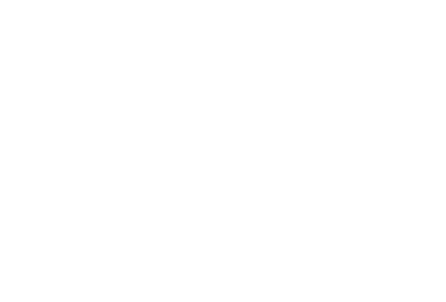

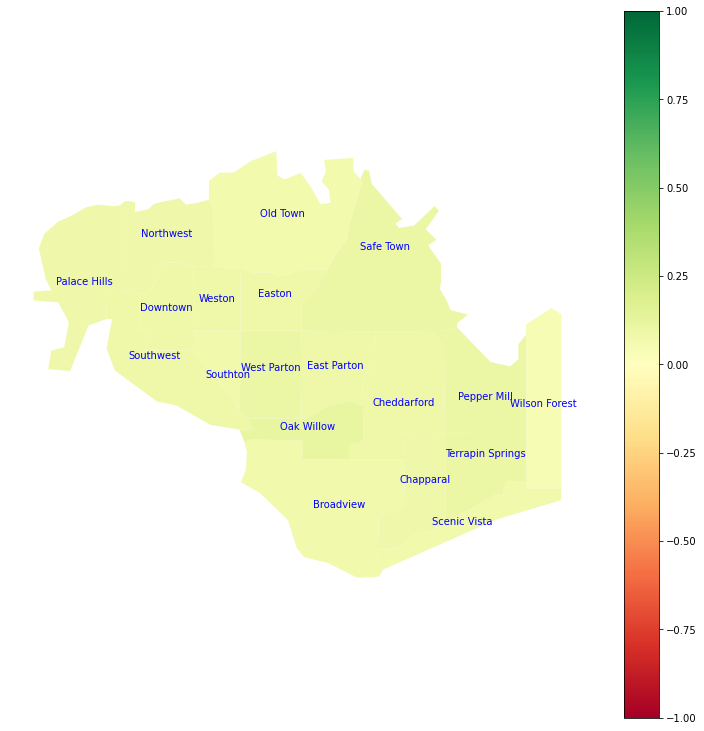

In [18]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)

fig, ax = plt.subplots(figsize = (13,13))
ax.axis('off')

Right_join['coords'] = Right_join['geometry'].apply(lambda x: x.representative_point().coords[:])
Right_join['coords'] = [coords[0] for coords in Right_join['coords']]

Right_join.plot(ax=ax, column='polarity',cmap ='RdYlGn', vmax = 1, vmin = -1, legend=True)

for idx, row in Right_join.iterrows():
    plt.annotate(text=row['Nbrhood'], xy=row['coords'], horizontalalignment='center', color='blue')
plt.savefig('map.png')

In [ ]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

# df = pd.read_csv("https://raw.githubusercontent.com/Coding-with-Adam/Dash-by-Plotly/master/Cytoscape/org-data.csv")
# df = pd.read_csv("df_final.csv")

fig = go.Figure(
    data = [go.Scatter(
    x=df_hour['hour'].astype(dtype=str), 
    y=df_hour['counts'], 
    marker_color='green',
    text="counts")],
    layout = go.Layout(
      title = {'text':'Tweets count from 2020-04-06 to 2020-04-10 hour by hour', 'x':0.5, 'xanchor':'center'},
      xaxis = {"title":"Time"},
      yaxis = {"title":"Total tweets count"},
      showlegend = False
    ),
)   

fig_line_graph = go.Figure(
    data = [go.Scatter(
    x = island_pol['Date_Hour'],
    y = island_pol['polarity'],
    mode = 'lines',
    name = "Overall sentiment across Island"
    )],
    layout = go.Layout(
                  title = {'text':'Islandwise Sentiment during the Earthquake week', 'x':0.5, 'xanchor':'center'},
                  xaxis = {"title":"Time"},
                  showlegend = False)
)

color_list = ["#4E79A7","#A0CBE8", "#F28E2B","#FFBE7D","#59A14F","#8CD17D","#B6992D","#F1CE63","#499894","#86BCB6","#E15759","#FF9D9A","#79706E","#BAB0AC","#D37295","#FABFD2","#B07AA1","#D4A6C8","#9D7660","#D7B5A6", "#000000"]

df_time = pd.to_datetime(df['time']).values.astype(np.int64) // 10 ** 9

map_png = 'map.png'
png_base64 = base64.b64encode(open(map_png, 'rb').read()).decode('ascii')

app.layout = html.Div([
    html.Div([
        dcc.RangeSlider(
            id='my-range-slider',
            min=df_time.min(),
            max=df_time.max(),
            value=[df_time.min(),df_time.max()],
            #marks={each : {"label": df_hour['hour'][each], "style": {"transform": "rotate(45deg)"}} for each, ts in enumerate(df_hour['ts'].unique())}
            marks= {int(df_hour['ts'][10]): str(df_hour['hour'][10]),
                    int(df_hour['ts'][20]): str(df_hour['hour'][20]),
                    int(df_hour['ts'][30]): str(df_hour['hour'][30]),
                    int(df_hour['ts'][40]): str(df_hour['hour'][40]),
                    int(df_hour['ts'][50]): str(df_hour['hour'][50]),
                    int(df_hour['ts'][60]): str(df_hour['hour'][60]),
                   int(df_hour['ts'][70]): str(df_hour['hour'][70]),
                   int(df_hour['ts'][80]): str(df_hour['hour'][80]),
                   int(df_hour['ts'][90]): str(df_hour['hour'][90]),
                   int(df_hour['ts'][100]): str(df_hour['hour'][100]),}
        ),
    ],style={'height': '50px', 'width': '100%','display': 'inline-block'}),
    html.Div([   
        dcc.Dropdown(
            id='slct_region',
            value=0,
            clearable=False,
            searchable=True,
            placeholder="Select a region",
            multi=False,
            options=[
                {'label': name.capitalize(), 'value':idx}
                for idx,name in enumerate(list_region)
            ]
        )
    ]),
    
    html.Div([
        html.Div([
            dcc.Graph(figure=fig)
        ], className='six columns'),
    
        html.Div([
            dcc.Graph(id='region_count')
        ], className='six columns'),
    ]),
    
    html.Div([
        # html.Img(src='data:image/png;base64,{}'.format(png_base64)),
        html.Img(id='map')
    ], className='six columns'),
    
    html.Div([
        dcc.Graph(
                    id ='line-graph',
                  figure = fig_line_graph)
    ], className='five columns'),
    
    html.Div([
        dash_table.DataTable(
        id='df-table',
        columns=[{"name": i, "id": i} for i in df_orginal.columns],
        data=df_orginal.to_dict('records'),
        filter_action='native',
        fixed_rows={'headers': True},
        style_cell_conditional=[
        {'if':{'column_id':'message'},
        'minWidth': '1200px','width': '1200px','maxWidth': '1200px'},
        {'if':{'column_id':'time'},
        'width': '120px'},
        {'if':{'column_id':'ts'},
        'minWidth': '0px','width': '0px','maxWidth': '0px'},
        {'if':{'column_id':'account'},
        'width': '120px'}
        ]  
        #style_table={
        #'height': 400,
        #}
            
        )
    ], className='row'),

    html.Div([
        html.Div(id='empty-div', children='')
    ],className='one column'),

    # html.Div([
    #     dcc.RangeSlider(
    #     id='my-range-slider',
    #     min=df_time.min(),
    #     max=df_time.max(),
    #     value=[df_time.min(),df_time.max()],
    #     #marks = {minute:minute for minute in df_time.unique()}
    # ),
    # ], className='five columns'),

  ], className='row')

@app.callback(
    Output('region_count','figure'),
    Input('slct_region','value')
)

def build_region_graph(slct_region):
    dff = df_region[slct_region]
    
    figure_region = px.line(dff, x="hour", y="counts")
    figure_region.update_layout(
        title= {'text':'Tweets count from 2020-04-06 to 2020-04-10 hour by hour in different region','x':0.5,'xanchor':'center'},
        xaxis= {"title":"Time"},
        yaxis= {"title":"Total tweets count"},
        showlegend= True)
    figure_region.update_xaxes(
        rangeslider_visible=True
    )
    
    return figure_region

@app.callback(
    Output('df-table','data'),
    Input('my-range-slider', 'value'),
    Input('slct_region', 'value')
)

def update_df(value_selected,slct_region):
    filter_df = df_orginal.loc[(df_orginal['ts']>=value_selected[0])&(df_orginal['ts']<=value_selected[1])]
    filter_df = filter_df.loc[filter_df['location']==list_region[slct_region]]
    data = filter_df.to_dict('records')
    return data
# @app.callback(
#     Output('my-graph','figure'),
#     Input('org-chart','tapNodeData'),
# )
# def update_nodes(data):
#     if data is None:
#         return no_update
#     else:
#         dff = df.copy()
#         dff.loc[dff.name == data['label'], 'color'] = "yellow"
#         fig = px.bar(dff, x='name', y='slaves_freed')
#         fig.update_traces(marker={'color': dff['color']})
#         return fig

@app.callback(
    Output('line-graph', 'figure'),
    Input('my-range-slider', 'value'),
)

def update_map(value):

    filter_df = df_line.loc[(df_line['ts']>=value[0])&(df_line['ts']<=value[1])]

    #### change df_line to filered df_line by callback
    array_grouped_df = []
    for i in filter_df['location'].unique():
      new_df = filter_df.loc[filter_df['location']==i].groupby("Date_Hour").mean()
      new_df['location'] = i
      array_grouped_df.append(new_df)

    result = pd.concat(array_grouped_df)
    result = result.drop(columns = 'index')
    result2 = result.reset_index()

    island_pol = result2.groupby("Date_Hour").mean()
    island_pol = island_pol.reset_index()

    fig_line_graph = go.Figure(
        data = [go.Scatter(
        x = island_pol['Date_Hour'],
        y = island_pol['polarity'],
        mode = 'lines',
        name = "Overall sentiment across Island"
        )],
        layout = go.Layout(
                      title = {'text':'Islandwise Sentiment during the Earthquake week', 'x':0.5, 'xanchor':'center'},
                      xaxis = {"title":"Time"},
                      showlegend = False)
    )
    
    Sentiment_df = result2.groupby("location").mean().reset_index()
    Sentiment_df.rename({'location':'Nbrhood'},axis=1,inplace=True)
    Sentiment_df = Sentiment_df[Sentiment_df.Nbrhood != 'UNKNOWN']
    Sentiment_df = Sentiment_df[Sentiment_df.Nbrhood != '<Location with-held due to contract>']
    
    
    St_Himark_Map = gpd.read_file("StHimark.shp")
    
    Right_join = pd.merge(St_Himark_Map, 
                      Sentiment_df, 
                      on ='Nbrhood',
                      how ='right')
    
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)

    fig, ax = plt.subplots(figsize = (13,13))
    ax.axis('off')

    Right_join['coords'] = Right_join['geometry'].apply(lambda x: x.representative_point().coords[:])
    Right_join['coords'] = [coords[0] for coords in Right_join['coords']]

    Right_join.plot(ax=ax, column='polarity',cmap ='RdYlGn', vmax = 0.5, vmin = -0.5, legend=True)

    for idx, row in Right_join.iterrows():
        plt.annotate(text=row['Nbrhood'], xy=row['coords'], horizontalalignment='center', color='blue')
    random_num = random.random()
    map_png = 'map.png'
    plt.savefig(map_png)
    png_base64 = base64.b64encode(open(map_png, 'rb').read()).decode('ascii')
    
    return fig_line_graph

@app.callback(
    Output('map','src'),
    Input('my-range-slider','value')
) 
def update_output(value):
    return 'data:image/png;base64,{}'.format(base64.b64encode(open('map.png', 'rb').read()).decode('ascii'))

if __name__ == '__main__':
    app.run_server(debug=False)

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [07/Dec/2021 04:30:13] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2021 04:30:13] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2021 04:30:14] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2021 04:30:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2021 04:30:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2021 04:30:15] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2021 04:30:15] "POST /_dash-update-component HTTP/1.1" 200 -
